In [10]:
import pandas as pd
from datetime import datetime

# 1. Traemos los datos
df = pd.read_excel('datos_sap_cartera.xlsx')

# 2. Convertir las fechas
df['Fecha Vencimiento (Zfbdt)'] = pd.to_datetime(df['Fecha Vencimiento (Zfbdt)'])

# 3. Definimos qué día es "Hoy"
hoy = datetime.now()

# 4. Calcular los días de retraso
def calcular_mora(fila):
    if fila['Estado'] == 'Pendiente':
        retraso = (hoy - fila['Fecha Vencimiento (Zfbdt)']).days
        return max(0, retraso)
    else:
        return 0

df['Dias_Mora'] = df.apply(calcular_mora, axis=1)

# 5. Clasificación de Riesgo
def clasificar(dias):
    if dias == 0: return 'Al día'
    if dias <= 30: return 'Riesgo Bajo'
    if dias <= 90: return 'Riesgo Medio'
    return 'Crítico (+90)'

df['Categoria_Riesgo'] = df['Dias_Mora'].apply(clasificar)

# 6. Ver el resultado final
# Usamos el nombre técnico de SAP que encontramos: 'Importe (Dmbtr)'
columnas_reporte = ['Nombre Cliente', 'Importe (Dmbtr)', 'Dias_Mora', 'Categoria_Riesgo']

# Mostramos los primeros 10 resultados del reporte
print("--- REPORTE DE CARTERA ACTUALIZADO ---")
print(df[columnas_reporte].head(10))

--- REPORTE DE CARTERA ACTUALIZADO ---
         Nombre Cliente  Importe (Dmbtr)  Dias_Mora Categoria_Riesgo
0  Construcciones Norte          4500000         63     Riesgo Medio
1  Construcciones Norte          2100000         18      Riesgo Bajo
2   Tiendas Retail S.A.           850000          0           Al día
3   Alimentos del Valle         12000000         89     Riesgo Medio
4      Logística Rápida          3200000         32     Riesgo Medio
5  Inversiones Globales          7400000        110    Crítico (+90)
6      Manufacturas ABC          1500000         13      Riesgo Bajo
7     Distribuidora Sur          5600000          0           Al día
8   Tecnología Avanzada          9000000          0           Al día
9  Servicios Integrales          2800000         69     Riesgo Medio


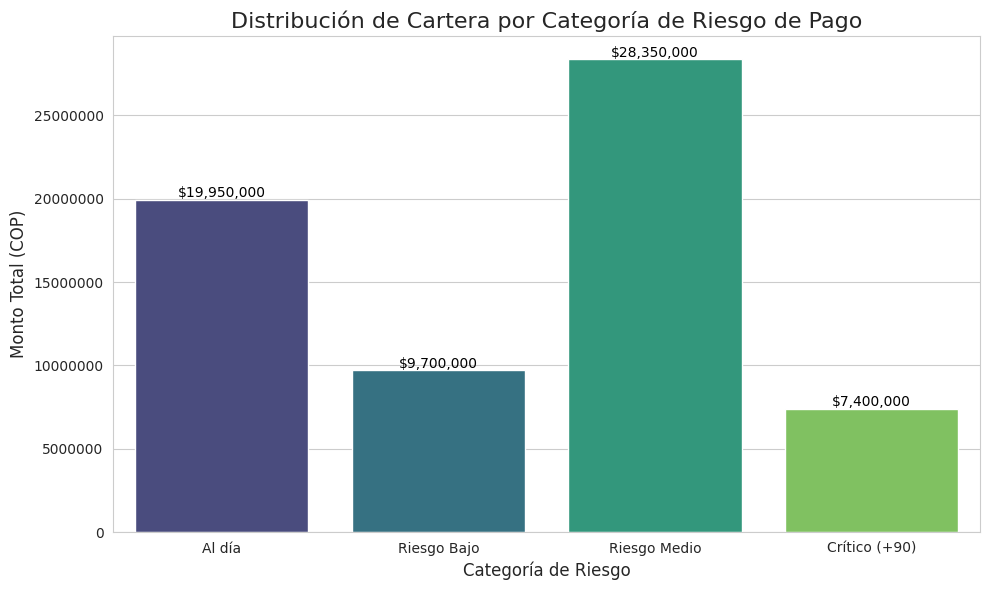

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Agrupamos los datos por Categoría de Riesgo
resumen_riesgo = df.groupby('Categoria_Riesgo')['Importe (Dmbtr)'].sum().reset_index()

# 2. Ordenamos las categorías para que el gráfico tenga sentido
orden_categorias = ['Al día', 'Riesgo Bajo', 'Riesgo Medio', 'Crítico (+90)']
resumen_riesgo['Categoria_Riesgo'] = pd.Categorical(resumen_riesgo['Categoria_Riesgo'], categories=orden_categorias, ordered=True)
resumen_riesgo = resumen_riesgo.sort_values('Categoria_Riesgo')

# 3. Configuramos el estilo del gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# 4. Creamos el gráfico de barras
# Ajustamos hue y legend para evitar el FutureWarning
ax = sns.barplot(x='Categoria_Riesgo', y='Importe (Dmbtr)', data=resumen_riesgo, hue='Categoria_Riesgo', palette='viridis', legend=False)

# 5. Añadimos títulos y etiquetas
plt.title('Distribución de Cartera por Categoría de Riesgo de Pago', fontsize=16)
plt.xlabel('Categoría de Riesgo', fontsize=12)
plt.ylabel('Monto Total (COP)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')

# Añadir los valores exactos sobre cada barra
for p in ax.patches:
    ax.annotate(f'${p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [16]:
# 1. Filtramos los datos para quedarnos solo con lo 'Crítico (+90)'
clientes_criticos = df[df['Categoria_Riesgo'] == 'Crítico (+90)']

# 2. Ordenamos por el monto más alto (para atacar primero lo más grande)
# Corregimos el nombre de la columna a 'Importe (Dmbtr)'
clientes_criticos = clientes_criticos.sort_values(by='Importe (Dmbtr)', ascending=False)

# 3. Imprimimos el reporte de acción
print("--- REPORTE DE ACCIÓN INMEDIATA: CLIENTES EN MORA CRÍTICA ---")
if not clientes_criticos.empty:
    for index, fila in clientes_criticos.iterrows():
        print(f"ALERTA: El cliente {fila['Nombre Cliente']} (ID: {fila['ID Cliente (Kunnr)']})")
        print(f"      Debe: ${fila['Importe (Dmbtr)']:,.0f} COP | Días de mora: {fila['Dias_Mora']}")
        print("-" * 50)
else:
    print("¡Felicidades! No hay clientes en estado crítico.")

--- REPORTE DE ACCIÓN INMEDIATA: CLIENTES EN MORA CRÍTICA ---
ALERTA: El cliente Inversiones Globales (ID: 400005)
      Debe: $7,400,000 COP | Días de mora: 110
--------------------------------------------------
